#Loading data

In [ ]:
!pip install pyldavis

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

In [ ]:
# Importing modules
import pandas as pd
import numpy as np
import re
import spacy
spacy.load('en')
import time
from spacy.lang.en import English
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import random
from wordcloud import WordCloud
from gensim import corpora
import pickle
import gensim
import pyLDAvis.gensim
from gensim.models import CoherenceModel
from collections import Counter
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore') 

In [ ]:
# Read data into papers
papers = pd.read_csv('papers.csv', engine='python')


# Select the related columns
papers_text = papers[['TI','DE', 'ID', 'AB', 'PY', 'SC','AF','NR','VL','FU','FX','IS','EA']]
papers_text = papers_text.replace(np.nan, ' ', regex=True)

# Combine columns 
papers_text["all_text"] = papers_text['TI'] + " " + papers_text['DE'] + " " + papers_text['ID']

# Print head
papers_text.head()

In [ ]:
TextForDomen=papers_text["all_text"]
TextForDomen.head()

# Data preprocessing

In [ ]:
parser = English()
parser = spacy.load('en')

# ----------------------- Tokenization 
def tokenize(text):
    en_stop2 = ['from', 'subject', 'edu', 'use', 'using', 'system', 'the', 'we', 'this'
                'base', 'propose', 'approach', 'application',
               'method', 'problem', 'performance', 'result', 'study', 
                'technique', 'paper', 'different', 
              'design', 'present', 'develop', 'number', 'improve', 'achieve', 
              'research', 'enhance', 'include', 'obtain', 'provide', 'solution', 'a', 'an' ]

    querywords = text.split()

    resultwords  = [word for word in querywords if word.lower() not in en_stop2]
    text = ' '.join(resultwords)

    lda_tokens = []
    noun_tokens = []
    tokens = parser(text)

    '''for token in tokens:
      token = token.lower_
      n_tokens = token.split()
      for n_token in n_tokens:
        noun_tokens.append(n_token)'''

    for token in tokens:
        #print ('---------------------pos', token.pos_)
        if token.orth_.isspace():
            continue
        #elif token.pos_ not in ['NOUN']:
            #continue
        #elif token.like_url:
            #lda_tokens.append('URL')
        #elif token.orth_.startswith('@'):
            #lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    
    return lda_tokens

# ----------------------- Lemmatization

def get_lemma(word):
    lemma = wn.morphy(word)#Morphy uses a combination of inflectional ending rules and exception lists to handle a variety of different possibilities print(wn.morphy('dogs'))dog, print(wn.morphy('churches'))church
    if lemma is None:
        return word
    else:
        return lemma

############### remove     

def get_lemma2(word):
  #tokens = parser(word)
  #if tokens[0].pos_ == 'NOUN':
    return WordNetLemmatizer().lemmatize(word)
  #else: 
   # return

# ----------------------- bigrams 
def make_bigrams(texts):
  bigram = gensim.models.Phrases(texts, min_count=3, threshold=0.1) # higher threshold fewer phrases
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  return [bigram_mod[doc] for doc in texts]

# ----------------------- trigrams 
def make_trigrams(texts):
  # Build the trigram models
  bigram = gensim.models.Phrases(texts, min_count=3, threshold=0.1)
  trigram = gensim.models.Phrases(bigram[texts], min_count=3, threshold=0.1) 
  # Faster way to get a sentence clubbed as a bigram
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  trigram_mod = gensim.models.phrases.Phraser(trigram)
  return [trigram_mod[bigram_mod[doc]] for doc in texts]

# ----------------------- Noun phrases 
def noun_phrases(texts):
  noun_text = []

  for text in texts:
    text = " ".join(text)
    text_pos = parser(text)
    tokens = [token for token in text_pos if token.pos_ == 'NOUN']
    tokens = " ".join([token.text for token in tokens]).split()
    noun_text.append(tokens)

  print ('noun_text1 =============================', noun_text[0])
  print ('noun_text2 =============================', noun_text[1])

  return noun_text


# ----------------------- Stop words 
nltk.download('stopwords')

# ----------------------- Preprocessing
def prepare_text_for_lda(tokens):
  en_stop = set(nltk.corpus.stopwords.words('english'))
  en_stop2 = ['from', 'subject', 'edu', 'use', 'using', 'system', 'the'
                'base', 'propose', 'approach', 'application',
               'method', 'problem', 'performance', 'result', 'study', 'all rights',
                'technique', 'paper', 'different', 'this study', 'this article', 'proposed algorithm', 'proposed solution',
              'design', 'present', 'develop', 'number', 'improve', 'achieve', 'obtained results', 'accuracy', 'proposed methodology' 
              'research', 'enhance', 'include', 'obtain', 'provide', 'solution', 'this paper', 'the results', 'experimental results', 'this work' ]
  #text = text.lower() 
  #text = re.sub('()[,\.!?;]', '', text)
  #tokens = tokenize(text)
  tokens = [token for token in tokens if len(token) > 4]
  tokens = [get_lemma(token) for token in tokens] 
  tokens = [get_lemma2(token) for token in tokens]
  tokens = [token for token in tokens if token not in en_stop]
  tokens = [token for token in tokens if token not in en_stop2]

  return tokens





In [ ]:
# ----------------------- Apply the preprocessing to the papers_text
def data_preprocess_before (papers_text):
  text_data_clean = []
  numPapers = 0

  for text in papers_text:
    text = re.sub('[^a-zA-Z ]','',text)#re.sub('-()[,\.!?;]123456789', '', text)#replace it with '--\(\)\]\[.%,80\.!\?;/|123456789\*\+\^@#$&"\''
    tokens = tokenize(text)
    text_data_clean.append(tokens)

  text_data_clean_bigrams = []
  for token in text_data_clean:
    #print (token)
    numPapers += 1
    tokens = prepare_text_for_lda(token)
    text_data_clean_bigrams.append(tokens)

  text_data_clean_bigrams = make_bigrams(text_data_clean_bigrams)
  text_data_clean_bigrams = make_trigrams(text_data_clean_bigrams)

  text_data_clean_bigrams= noun_phrases (text_data_clean_bigrams)

  print (numPapers)

  return text_data_clean_bigrams

# Visualization 

In [ ]:

def word_cloud (texts):
  # Join the different processed titles together.
  long_string = [','.join(text) for text in texts]
  long_string = ','.join(long_string)
  # Create a WordCloud object
  wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
  # Generate a word cloud
  cloud = wordcloud.generate(long_string)
  # Visualize the word cloud
  cloud.to_image()
  cloud.to_file('wordcloud.png')


def LDA_Vis ():
  dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
  corpus = pickle.load(open('corpus.pkl', 'rb'))
  lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
  lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
  pyLDAvis.display(lda_display)


# LDA with Gensim

In [ ]:
def DLDA (text_data):
  dictionary = corpora.Dictionary(text_data)
  corpus = [dictionary.doc2bow(text) for text in text_data]

  pickle.dump(corpus, open('corpus_KSU.pkl', 'wb'))
  dictionary.save('dictionary_KSU.gensim')
  start_time = time.time()
  ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
  ldamodel.save('model_LDA_KSU.gensim')
  topics = ldamodel.print_topics(num_words=NUM_WORDS)
  fit_time = round((time.time() - start_time))
  print ('The time it take to build the model =', fit_time)

  # Compute Perplexity
  print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

  # Compute Coherence Score
  coherence_model_lda = CoherenceModel(model=ldamodel, texts=text_data, dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  print('\nCoherence Score: ', coherence_lda)

  for topic in topics:
      print(topic)
  
  return dictionary, corpus, text_data

In [ ]:
# to select the best number of topics 
def compute_coherence_values(dictionary, corpus, texts, limit, start=50, step=5):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary, passes=15)
        model_list.append(model)
        print('\nPerplexity: ', model.log_perplexity(corpus)) 
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# to find the main research areas 
def areas ():
  areas = []
  papers_areas = papers[['SC']]
  papers_areas = papers_areas.drop_duplicates()
  papers_areas = papers_areas.dropna()
  papers_areas = papers_areas['SC'].tolist()
  papers_areas = ';'.join(papers_areas) 
  papers_areas = papers_areas.split(";") 
  papers_areas = [re.sub('- Other Topics', '', area) for area in papers_areas]
  papers_areas = [re.sub(' ', '', area) for area in papers_areas]
  print (papers_areas)
  counts = Counter(papers_areas)
  counts = counts.most_common(10)
  print(counts) 

areas ()

## **Run LDA model** 

In [ ]:
start_time = time.time()
text_data = data_preprocess_before (papers_text["all_text"])

fit_time = round((time.time() - start_time))
print ('The time it take to preprocess the data=', fit_time)
word_cloud (text_data)

# LDA has two parameters number of topics and number of words per topic 
NUM_TOPICS = 105
NUM_WORDS = 20

dic, cor, data = DLDA (text_data)



In [ ]:
print('The number of tokens is === ', len(dic))

In [ ]:
# Select optimal number of topic 
model_list, coherence_values = compute_coherence_values(dictionary=dic, corpus=cor, texts=data, start=50, limit=, step=5)

In [ ]:
# Show graph
from matplotlib.pyplot import figure

limit=170; start=50; step=5;
x = range(start, limit, step)
#for m, cv in zip(x, coherence_values):
    #print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

fig, ax = plt.subplots()
ax.plot(x,coherence_values)

def annot_max(x,coherence_values, ax=None):
    xmax = x[np.argmax(coherence_values)]
    ymax = max(coherence_values)
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(x,coherence_values)


ax.set_ylim(-0.3,1.5)
plt.show()

In [ ]:
# visualize the topics 
LDA_Vis ()
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

## **10 Topics**

In [ ]:

# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.597234123516133

Coherence Score:  0.4362070026325687


##**164 Topics 20 words** 

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=164, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# visualize the topics 
LDA_Vis ()
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model164.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

##**50 Topics 20 words** 

In [ ]:
text_data = data_preprocess_all ()
word_cloud (text_data)

# LDA has two parameters number of topics and number of words per topic 
NUM_TOPICS = 50
NUM_WORDS = 15
dic, cor, data,topics = LDA_p (text_data)


# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(cor))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model_50_topics.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [ ]:
# ----------------------- Apply the preprocessing to the papers_text

def data_preprocess_all_year (area):
  text_data_clean = []
  #papers_text_year = papers_text.loc[(papers_text['PY'] == year)]
  numPapers = 0
  for index, text in papers_text.iterrows():
    if area in text['SC']:
      numPapers += 1
      tokens = prepare_text_for_lda(text["all_text"])
      text_data_clean.append(tokens)
      # used to print parts of the data randomly 
      #if random.random() > .99:
      print (tokens)
  print (numPapers)

  return text_data_clean

In [ ]:
text_data = data_preprocess_all_year('Computer Science')
#word_cloud (text_data)

# LDA has twoparameters number of topics and number of words per topic 
NUM_TOPICS = 20
NUM_WORDS = 15
dic, cor, data,topics = LDA_p (text_data)


# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(cor))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model_20_topics_CS.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

# DTM with Gensim

In [ ]:
#downolad and build DTM binary 
!git clone https://github.com/blei-lab/dtm.git
!sudo apt-get install libgsl0-dev
!cd dtm/dtm;make

## Sort Recored by Years.

In [ ]:
papers_by_years=papers_text.sort_values('PY')
papers_by_years.head()

TI  ...                                           all_text
0     Zwitterionic surface grafting of epoxylated su...  ...  Zwitterionic surface grafting of epoxylated su...
2216  Intermediate Type of Obstetric Brachial Plexus...  ...  Intermediate Type of Obstetric Brachial Plexus...
2213  Internet banking service quality and its impli...  ...  Internet banking service quality and its impli...
2209  INTERNET OF THINGS CLOUD: ARCHITECTURE AND IMP...  ...  INTERNET OF THINGS CLOUD: ARCHITECTURE AND IMP...
2207  Internet of Vehicles : Motivation, Layered Arc...  ...  Internet of Vehicles : Motivation, Layered Arc...

[5 rows x 14 columns]

In [ ]:
#the number of papers in each year
papers_by_years['PY'].value_counts()

##Main

In [ ]:
import logging
logging.basicConfig(level=logging.INFO )

In [ ]:
def DTM (text_year):


  dictionary = corpora.Dictionary(text_year )
  corpus = [dictionary.doc2bow(text) for text in text_year ]

  pickle.dump(corpus, open('corpus_sorted_KSU.pkl', 'wb'))
  dictionary.save('dictionary_sorted_KSU.gensim')


  path_to_dtm_binary = "./dtm/dtm/main" #/content/drive/MyDrive/NLP_LDA/dtm/dtm/main"#
  start_time = time.time()
  dtmmodel = DtmModel(
    path_to_dtm_binary,
     corpus=corpus,
      id2word=dictionary, 
      num_topics=TOPICS,
     time_slices=TIMES)# ,model='Fixed')
  fit_time = round((time.time() - start_time))
  print ('The time it take to build the model =', fit_time)
  dtmmodel.save('DTM_5_KSU.gensim')
  #dtmmodel = DtmModel.load('/content/drive/MyDrive/NLP_LDA/DTM_1_noun.gensim')
  topics = dtmmodel.print_topics(times=5,num_words=NUM_WORDS)
  
  # Compute Perplexity
  print('\nPerplexity: ', sum(dtmmodel.lhood_)/len(dtmmodel.lhood_))  # a measure of how good the model is. lower the better.
  
  # Compute Coherence Score
  coherence_dtm =[]
  for t in range(0,5):
    coherence_topics=dtmmodel.dtm_coherence(t,num_words=NUM_WORDS)
    coherence_model_dtm = CoherenceModel(topics=coherence_topics, texts=text_year, corpus=corpus, dictionary=dictionary, coherence='c_v')
    coherence_dtm.append(coherence_model_dtm.get_coherence())
  print('\nCoherence Score: ', sum(coherence_dtm)/len(coherence_dtm))
  
  return dictionary, corpus, text_year,dtmmodel.lhood_,coherence_dtm

In [ ]:

from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.wrappers import DtmModel


start_time = time.time()
text_year = data_preprocess(papers_by_years['all_text'])
fit_time = round((time.time() - start_time))
print ('The time it take to preprocess the data=', fit_time)

'''2019    1438
2020    1327
2018    1280
2017    1181
2016    1096'''

#TIMES=[1096,1181,1280,1438,1327] #KFUPM
TIMES=[970,971,985,941,818] #KSU

NUM_TOPICS = 95 #105
NUM_WORDS = 20



dic, cor, data, preplexty,coherence_dtm = DTM(text_year)




print("preplexity:",preplexty)
print("coherence per year:",coherence_dtm)

##Compute best number of topics based on coherence

In [ ]:
# to select the best number of topics 
from gensim.models.wrappers import DtmModel
TIMES=[1096,1181,1280,1438,1327]
NUM_TOPICS = 164
NUM_WORDS = 20
def compute_coherence_values_DTM(dictionary, corpus, text, limit=170, start=50, step=5):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        path_to_dtm_binary = "./dtm/dtm/main"
        model = DtmModel(path_to_dtm_binary, corpus=corpus,id2word=dictionary,  num_topics=num_topics,time_slices=TIMES )
        model_list.append(model)
         # Compute Coherence Score
        coherence_dtm =[]
        for t in range(0,5):
            coherence_topics=model.dtm_coherence(t,num_words=NUM_WORDS)
            coherence_model_dtm = CoherenceModel(topics=coherence_topics, texts=text, corpus=corpus, dictionary=dictionary, coherence='c_v')
            coherence_dtm.append(coherence_model_dtm.get_coherence())
        print('\nCoherence Score with ',num_topics, ' topics is: ',sum(coherence_dtm)/len(coherence_dtm))
        coherence_values.append(coherence_dtm)

    return model_list, coherence_values

cor = pickle.load(open('/content/drive/MyDrive/NLP_LDA/corpus_DTM_4_stopword_before.pkl', 'rb'))
dic=gensim.corpora.Dictionary.load('/content/drive/MyDrive/NLP_LDA/dictionaryDTM_4_stopword_before.gensim')
model_list, coherence_values=compute_coherence_values_DTM(dic,cor,text=text_year)



##Visulization

In [ ]:
from gensim.models.wrappers import DtmModel
dtmmodel = DtmModel.load('DTM_5_KSU.gensim')
corpus = pickle.load(open('corpus_sorted_KSU.pkl', 'rb'))
dictionary=gensim.corpora.Dictionary.load('dictionary_sorted_KSU.gensim')

In [ ]:
#save the top 20 words for each topics
topicswords=dtmmodel.print_topics(num_topics=105, times=5, num_words=20)
topics_words=pd.DataFrame(topicswords)
topics_words.to_csv('topics_words_KSU.csv')


###Topics

In [ ]:
#https://github.com/GSukr/dtmvisual/blob/master/dtmvisual/VisualizeTopics.py
import pprint
def print_all_topics(model, topicid = None, time = None, num_words=10):
    
    """ function to output top words with pprint 
    :param model: dtm_model
    :param topicid: number of topic
    :param time: number of time period
    :param num_topics: number of words to display for the topicid at the time period
    """
    
    pp = pprint.PrettyPrinter(indent=4)
    for topic in range(topicid):
        for time in range(time):
            print("Topic#",topic,", Time ",time)
            pp.pprint(model.show_topic(topicid, time, num_words))
def document_influence_dim(num_topics, model, time_seq = []):
    
    """
    function to compute the document influence on a topic: http://users.umiacs.umd.edu/~jbg/nips_tm_workshop/30.pdf 
    :param num_topics: number of topics
    
    """
    
    doc, topicId, period, distributions=[], [], [], []
    for topic in range(num_topics):
        for t in range(len(time_seq)):
            for document in range(time_seq[t]):
                #print(t,document,topic,model.influences_time)
                #round(topic_counts/topic_counts.sum(), 4)
                distribution = -100#round(model.influences_time[t][document][topic], 4)# round(model.lhood_[t+document+topic], 4)
                period.append(t)
                doc.append(document)
                topicId.append(topic)
                distributions.append(distribution)
    return pd.DataFrame(list(zip(doc, topicId, period, distributions)), columns=['document','topicId', 'period','distribution'])
def topic_distribution(num_topics, model, time_seq = []):
    
    """
    function to compute the topical distribution in a document
    :param num_topics: number of topics
    
    """
    doc, topicId, distributions=[], [], []
    df_dim = document_influence_dim(num_topics = num_topics, model = model, time_seq = time_seq)
    for document in range(0, sum(time_seq)):
        for topic in range(0, num_topics):
            distribution = round(model.gamma_[document][topic], 4)
            doc.append(document)
            topicId.append(topic)
            distributions.append(distribution)
    return pd.DataFrame(list(zip(doc, topicId, distributions, df_dim.period)), columns=['document','topicId', 'distribution', 'period'])



def visualize_topics(df):
    
    """
    function to vizualise mean topic distribution over defined periods
    :param num_topics: number of topics
    
    """
    
    fig, ax = plt.subplots(figsize=(25,15))
    ax.xaxis.label.set_size(18)
    #fig.suptitle('Topic evolution', fontsize=16)
    df.groupby(['period','topicId'], sort=False).mean()['distribution'].unstack().plot(ax=ax,grid=True, linewidth =3.0, sharex=True)
    plt.ylabel("Topic Distribution", fontsize=16) 
    plt.xticks(ticks=[0,1,2,3,4],labels=["2016","2017","2018","2019","2020"],fontsize=16)
    plt.xlabel("Years", fontsize=16) 
    plt.title("Topic evolution", fontdict = {'fontsize' : 24})
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = "Topics", fontsize='large', labelspacing=0.6, fancybox = True)
    

In [ ]:
df

document  topicId  distribution  period
100            0      100        0.0014       0
101            0      101        0.0014       0
102            0      102        0.0014       0
103            0      103        0.0014       0
104            0      104        0.0014       0
...          ...      ...           ...     ...
663805      6321      100        0.0011       4
663806      6321      101        0.0011       4
663807      6321      102        0.0011       4
663808      6321      103        0.0011       4
663809      6321      104        0.0011       4

[31610 rows x 4 columns]

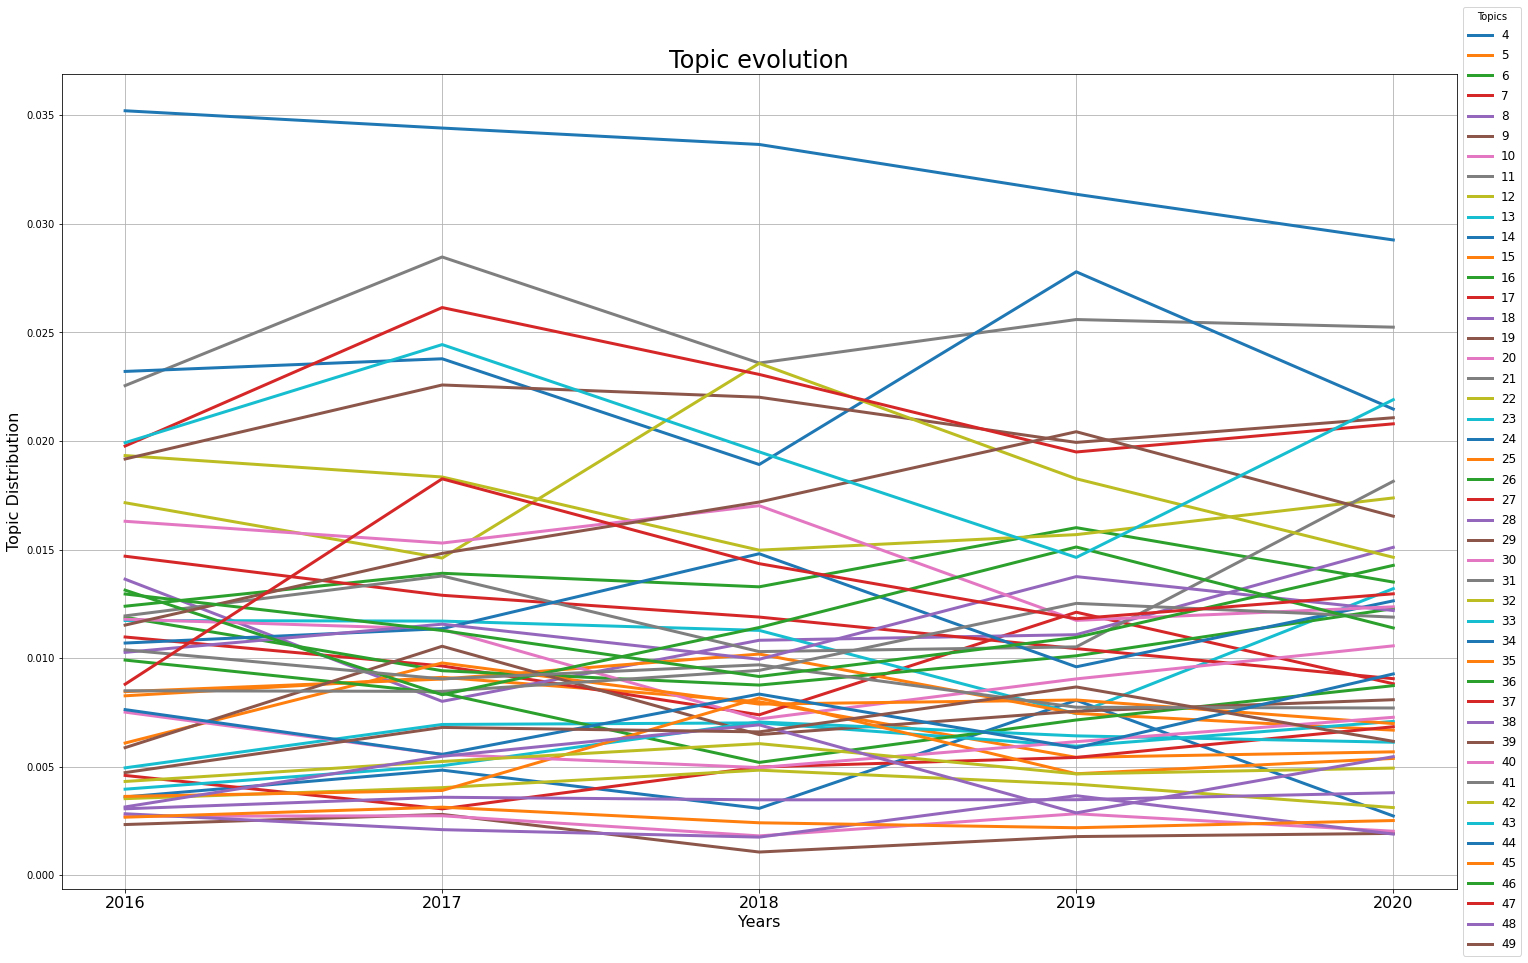

In [ ]:
#Create the dataframe with the topical distribution in a document:
#TIMES=[1096,1181,1280,1438,1327]
NUM_TOPICS=95
df = topic_distribution(NUM_TOPICS, dtmmodel, TIMES)
#df=df.loc[df['topicId'].isin([33,9,8,6,64,27,53,87,71,34])]
df=df[df['topicId']>3] #lower bound
df=df[df['topicId']<50] #upper bound
visualize_topics(df)


In [ ]:
df.to_csv('CSVgropedbyPirodTopicidDistribution.csv')

In [ ]:
topic_distubution=topic_distribution(105, dtmmodel, TIMES)
topic_distubution
#topic_distubution.to_csv("doc_dist4all.csv")

document  topicId  distribution  period
0              0        0        0.0009       0
1              0        1        0.0009       0
2              0        2        0.0009       0
3              0        3        0.0009       0
4              0        4        0.0009       0
...          ...      ...           ...     ...
491920      4684      100        0.0010       4
491921      4684      101        0.0010       4
491922      4684      102        0.0010       4
491923      4684      103        0.0010       4
491924      4684      104        0.0010       4

[491925 rows x 4 columns]

###Words

In [ ]:
#https://github.com/GSukr/dtmvisual/blob/master/dtmvisual/visualize_words.py
def DF(timespans, num_topics, model, num_words = 20):
    
    """
    :param timespans: number od timespans/periods
    :param num_topics: number of topics
    :param model: DTM trained model
    :param num_words: number of words to display for the topicid at the time period
    :return: Dataframe with corresponding weight for each top word in each topic of each period
    """
    topicId, period, weight, word = [], [], [], []
    for t in range(timespans):
        for s in range (num_topics):
            topics = model.show_topic(topicid=s, time=t, num_words=num_words)
            for i, (word_, w) in enumerate(topics):
                topicId.append(s)
                period.append(t)
                weight.append(w)
                word.append(word_)
    return pd.DataFrame(list(zip(topicId, period, weight, word)), columns = ['topicId', 'period', 'word', 'weight',])

def partitioning(df):
    
    """
    :param df: Dataframe with corresponding weight for each top word in each topic of each period
    :return: partition based on TopicID
    
    """
    
    d = {} # d[i] contains records for TopicID i
    for topic in list(df['topicId'].unique()): # for each topic
        d[topic] = df.loc[df['topicId'] == topic] # create dataframe with records
        print('Number of records for Topic %d = %d' %(topic, len(d[topic])))
    return d

def displayTopic(d, i):
    
    """
    function to display Word-Probability by period for topic i
    """
    s = d[i][['period', 'word', 'weight']]
    fig, ax = plt.subplots(figsize=(15,10))
    k=2016
    for key, grp in s.groupby(['word']):
        ax = grp.plot(ax=ax, kind='line', x='period', y='weight', fontsize=12, label=key, linewidth=2.5)
    plt.xticks(ticks=[0,1,2,3,4],labels=["2016","2017","2018","2019","2020"])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = "Top keywords", fontsize='large', labelspacing=0.6, fancybox = False)
    plt.savefig(""+str(i)+".png", bbox_inches='tight')
    plt.show()
        
def visualize_words(df, d):
    """
    function to visualize words evolution
    """
    
    for topic in list(df['topicId'].unique()):
        displayTopic(d, topic)
        
        s = d[topic][['period', 'word', 'weight']]


        print("\nResults for the topic: ", topic)

In [ ]:

#Create a dataframe with the columns ['topicId', 'period', 'word', 'weight']:
df = DF(5, 105, dtmmodel)
#Ensure the words partition based on TopicID:
d = partitioning(df)
visualize_words(df, d)

##Topics Year 0 

In [ ]:
print("Topic #0")
for i in range(1,5):
  topics = model.show_topic(topicid=0, time=i, num_words=20)
  print("Year "+str(i)+" :",topics)


In [ ]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = model.dtm_vis(time=0, corpus=common_corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency,sort_topics=False)
pyLDAvis.display(vis_wrapper)

##Topics Year 1

In [ ]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = model.dtm_vis(time=1, corpus=common_corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency,sort_topics=False)
pyLDAvis.display(vis_wrapper)

##Topics Year 5

In [ ]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = model.dtm_vis(time=5, corpus=common_corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency,sort_topics=False)
pyLDAvis.display(vis_wrapper)

#Useful information about topics and document

In [ ]:
from gensim.models.wrappers import DtmModel
dtmmodel = DtmModel.load('DTM_5_KSU.gensim')
corpus = pickle.load(open('corpus_sorted_KSU.pkl', 'rb'))
dictionary=gensim.corpora.Dictionary.load('dictionary_sorted_KSU.gensim')

##Average Topic distubution

In [ ]:
#extracting average topic proportion in each year
ty= topic_distribution(NUM_TOPICS, dtmmodel, TIMES)
Trend_topics=ty.groupby(['period', 'topicId'], sort=False).mean()['distribution'].unstack()

Trend_topics.to_csv("trend_topic_KSU.csv") 

In [ ]:
Trend_topics


In [ ]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = dtmmodel.dtm_vis(time=4, corpus=cor)
print(len(doc_topic))

## Dominant topic in each paper

In [ ]:
import numpy as np
def format_topics_sentences(dtmmodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
   # print("Yarab",texts.iloc[1841])
    # Get main topic in each document
    for i, row in enumerate(doc_topic):

        prop_topic= np.amax(row)
        topic_num = np.argmax(row, axis=0) #text[i]
        #if i==1841:
        #  print("doc_no",i," topics_no",topic_num,"  prop",prop_topic,"     text",texts.iloc[i])
        #print(row)
        #row = sorted(row, key=lambda x: (x[1]), reverse=True)
        sent_topics_df = sent_topics_df.append(pd.Series([i,int(topic_num), round(prop_topic,4),texts['TI'].iloc[i],texts['DE'].iloc[i],texts['ID'].iloc[i],texts['AB'].iloc[i],texts['PY'].iloc[i],texts['SC'].iloc[i],texts['AF'].iloc[i],texts['NR'].iloc[i],texts['VL'].iloc[i],texts['FU'].iloc[i],texts['FX'].iloc[i],texts['IS'].iloc[i],texts['EA'].iloc[i],texts['all_text'].iloc[i]] ),ignore_index=True)
        
    sent_topics_df.columns = ['Document_No','Dominant_Topic', 'Perc_Contribution','TI','DE', 'ID', 'AB', 'PY', 'SC','AF','NR','VL','FU','FX','IS','EA','all_text']

    # Add original text to the end of the output
    #contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, texts], axis=1)
    return(sent_topics_df)
corpus[1841]

doc_topic, topic_term, doc_lengths, term_frequency, vocab = dtmmodel.dtm_vis(time=0, corpus=corpus)
print(len(doc_topic))
df_topic_sents_keywords = format_topics_sentences(dtmmodel=dtmmodel, corpus=corpus, texts=papers_by_years)
# Format
df_dominant_topic = df_topic_sents_keywords

#save
df_dominant_topic.to_csv('95_Dominant_Topic_for_all_papers_KSU.csv')
# Show
df_dominant_topic.head(105)

4685


Document_No  ...                                           all_text
0            0.0  ...  Zwitterionic surface grafting of epoxylated su...
1            1.0  ...  Zwitterionic Modifications for Enhancing the A...
2            2.0  ...  Zwitterionic fibrous polypropylene assembled w...
3            3.0  ...  ZnSe-WO3 nano-hetero-assembly stacked on Gum g...
4            4.0  ...  ZnO/MnOx Nanoflowers for High-Performance Supe...
..           ...  ...                                                ...
100        100.0  ...  Validity of the motivated strategies for learn...
101        101.0  ...  Validity and feasibility of the Arabic version...
102        102.0  ...  VALIDATION OF THREE-DIMENSIONAL AIRWAY IMAGING...
103        103.0  ...  Validation of Arabic version of the Modified D...
104        104.0  ...  Vaccination status of patients using anti-TNF ...

[105 rows x 31 columns]

##The most representative document for each topic




In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=False, inplace=True)

# Format
#sent_topics_sorteddf_mallet.columns = ['Document_No','Topic_Num', "Topic_Perc_Contrib", "Text"]
sent_topics_sorteddf_mallet.to_csv('105The most representative document for each topic_KSU.csv')
# Show
sent_topics_sorteddf_mallet


index  ...                                           all_text
0    4217  ...  Analysis of a new model of H1N1 spread: Model ...
1    1930  ...  Micelles as Soil and Water Decontamination Age...
2     409  ...  THE EFFECTIVENESS OF CARBON DIOXIDE AND NITROG...
3    3341  ...  Discovery of diazahexa/hepta cyclic cage-like ...
4    4007  ...  Automatic detection of lung cancer from biomed...
..    ...  ...                                                ...
90   1039  ...  Reply to Letter to Editor RE: Laparoscopic Sle...
91   1816  ...  Morphodynamic changes as an impact of human in...
92   3377  ...  Development of new organic-inorganic, hybrid b...
93   2234  ...  Intelligent temporal classification and fuzzy ...
94     72  ...  Video on Demand Over Optical Wireless Communic...

[95 rows x 32 columns]